In [36]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.models import load_model
import matplotlib.pyplot as pyplot

In [168]:
# define the standalone discriminator model
def define_discriminator(in_shape=(48,48,1), n_classes=7):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [176]:
define_discriminator().summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 50)        350         input_19[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 1, 2304)      117504      embedding_10[0][0]               
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 48, 48, 1)    0                                            
___________________________________________________________________________________________

In [238]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=7):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 12 * 12
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((12, 12, 1))(li)
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    
    # foundation for 7x7 image
    n_nodes = 128 * 12 * 12
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((12, 12, 128))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, li]) #(None, 7, 7, 129)
    
    # upsample to 24x24
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)    
    
    # upsample to 48x48
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # output
    out_layer = Conv2D(1, (12,12), activation='tanh', padding='same')(gen)
    
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [235]:
define_generator(100)

(None, None, None, 128)


In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [209]:
# load face images
def load_real_samples():
    trainX=pickle.load(open('trainX.pkl', 'rb'))
    trainy=pickle.load(open('trainy.pkl', 'rb'))
    
    trainX = expand_dims(trainX, axis=-1)
    trainX = trainX.astype('float32')
    trainX = (trainX - 127.5) / 127.5
    return [trainX, trainy]

In [13]:
# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

In [216]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=7):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [15]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [217]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('cgan_generator.h5')

In [239]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
print(d_model.summary())
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, 
      d_model, 
      gan_model, 
      dataset, 
      latent_dim,
      n_epochs=1)

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 1, 50)        350         input_61[0][0]                   
__________________________________________________________________________________________________
dense_61 (Dense)                (None, 1, 2304)      117504      embedding_31[0][0]               
__________________________________________________________________________________________________
input_62 (InputLayer)           (None, 48, 48, 1)    0                                            
___________________________________________________________________________________________

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/hs/Desktop/Projects/my_projects

>1, 1/280, d1=0.688, d2=0.695 g=0.691


/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/280, d1=0.628, d2=0.703 g=0.684
>1, 3/280, d1=0.560, d2=0.720 g=0.669
>1, 4/280, d1=0.516, d2=0.749 g=0.648
>1, 5/280, d1=0.459, d2=0.788 g=0.626
>1, 6/280, d1=0.420, d2=0.831 g=0.619
>1, 7/280, d1=0.382, d2=0.823 g=0.650
>1, 8/280, d1=0.358, d2=0.746 g=0.752
>1, 9/280, d1=0.378, d2=0.632 g=0.877
>1, 10/280, d1=0.307, d2=0.555 g=0.953
>1, 11/280, d1=0.271, d2=0.549 g=0.919
>1, 12/280, d1=0.374, d2=0.599 g=0.821
>1, 13/280, d1=0.314, d2=0.663 g=0.741
>1, 14/280, d1=0.213, d2=0.748 g=0.672
>1, 15/280, d1=0.232, d2=0.906 g=0.574
>1, 16/280, d1=0.264, d2=1.121 g=0.487
>1, 17/280, d1=0.257, d2=1.254 g=0.451
>1, 18/280, d1=0.246, d2=1.275 g=0.467
>1, 19/280, d1=0.231, d2=1.178 g=0.525
>1, 20/280, d1=0.264, d2=1.090 g=0.631
>1, 21/280, d1=0.234, d2=0.891 g=0.859
>1, 22/280, d1=0.254, d2=0.563 g=1.330
>1, 23/280, d1=0.328, d2=0.304 g=1.757
>1, 24/280, d1=0.288, d2=0.218 g=1.961
>1, 25/280, d1=0.291, d2=0.230 g=1.775
>1, 26/280, d1=0.344, d2=0.353 g=1.311
>1, 27/280, d1=0.321, d2=0.500 g=

KeyboardInterrupt: 

## Generating new images

In [38]:
from keras.models import load_model
from numpy import asarray

In [337]:
randn(100)

array([-0.36813999,  0.27404943, -1.21118949,  1.56801526, -1.29650977,
       -0.12655014,  0.11442155,  0.62285845,  1.85138647,  0.70328577,
        0.25889186,  0.80522803, -0.59949871, -0.57461564, -1.02795687,
       -0.85317236,  0.12146409, -2.03686173,  0.16102434,  0.16075718,
        0.12167754, -0.80746387,  1.12597939, -0.2498593 ,  0.83906891,
        0.54128334,  0.70209309,  0.97614669, -0.0864625 ,  0.98075666,
        0.38536982,  0.56929358,  0.35372931,  0.72396114,  0.65302913,
       -0.73635081, -1.53077594,  1.00859898,  0.36890451,  2.13997659,
       -0.50689478,  0.05435053, -1.37324539, -1.42636759,  0.12329463,
       -0.53644608, -0.80845509,  1.26438306, -0.94280841,  1.18292401,
        1.05364424, -0.24240931, -0.37806907,  0.19139086, -0.53950615,
       -0.89555662, -1.62695543,  0.21997841,  0.14891318, -2.32654441,
       -0.60281681, -0.91323095,  0.75597163,  2.91050393, -1.02083215,
       -0.85656743, -0.31163565,  0.73586278,  1.05472281,  2.07

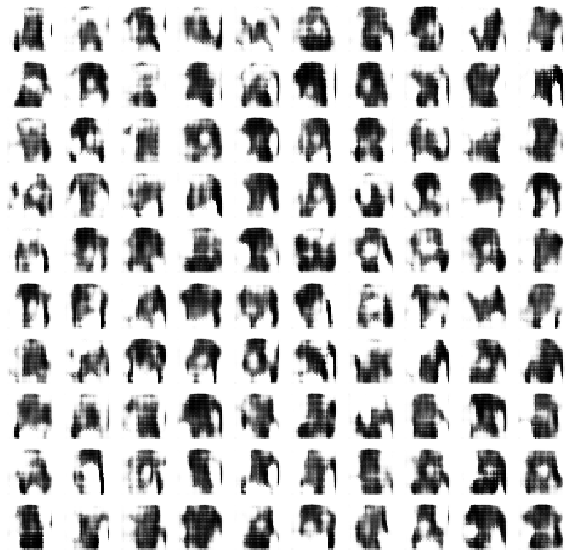

In [42]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    pyplot.figure(figsize=(10,10))
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

In [20]:
(trainX, trainy), (_, _) = load_data()

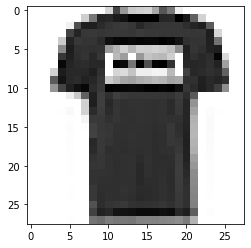

In [30]:
pyplot.imshow(trainX[1], cmap='gray_r')

In [45]:
trainX[0].shape

(28, 28)

In [62]:
import pandas as pd
import numpy as np

In [109]:
df=pd.read_csv('/home/hs/Desktop/Projects/speech_emotion_recognition/616504_1103829_bundle_archive/fer2013/fer2013.csv')

In [110]:
def convert_to_array(row):
    row=np.array(list(map(int, row.split())))
    row=np.reshape(row, (48,48))
    return row

df.pixels=df.pixels.apply(convert_to_array)

In [200]:
def generate_xy():
    trainy=df.emotion.values

    arr=df.pixels.values
    final=[]
    final.extend([x for x in arr])
    trainX=np.array(final)
    
    pickle.dump(trainX, open('trainX.pkl', 'wb'))
    pickle.dump(trainy, open('trainy.pkl', 'wb'))

In [265]:
indices=np.where(trainy==0)

In [267]:
indices[0]

0

In [ ]:
0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [305]:
from IPython.display import display
def plot_emotion(emotion_id):
    indices=np.where(trainy==emotion_id)[0]
    idx=np.random.choice(indices, replace=False)
    pyplot.imshow(trainX[idx, :, :], cmap='gray')

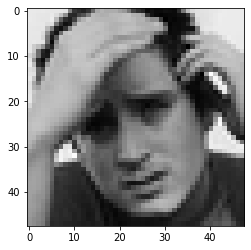

In [341]:
plot_emotion(2)

In [339]:
from collections import Counter
Counter(trainy)

Counter({0: 4953, 2: 5121, 4: 6077, 6: 6198, 3: 8989, 5: 4002, 1: 547})

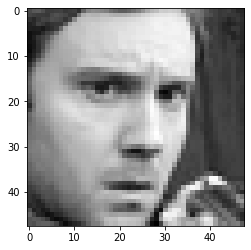

In [246]:
pyplot.imshow(trainX[0, :, :], cmap='gray')

In [333]:
import random

In [335]:
np.random.randint(0,5,10)

array([2, 2, 2, 3, 4, 4, 2, 1, 3, 0])